In [2]:
# Import bibliotek

import pandas as pd
import numpy as np


!pip install -q tensorflow
!pip install -q spacy
!python -m spacy download en_core_web_md -q
!pip install Wordcloud -q
!pip install accelerate -q
!pip install transformers -q
!pip install datasets -q

import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import tensorflow as tf

from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, f1_score, roc_curve

from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding, Dropout
from tensorflow.keras.layers import Activation, Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D

from keras.models import Sequential

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

#from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import time

import en_core_web_sm

2023-12-20 16:09:36.543358: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 16:09:36.543410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 16:09:36.544905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 16:09:36.552274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 16:09:37.592148: W tensorflow/comp

In [3]:
!pip install -U accelerate==0.20.3 -q
import accelerate
!pip install transformers -q
import transformers

#!pip install accelerate -U -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 4.8 MB/s eta 0:00:00


In [4]:
# Baza danych

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/tripadvisor_hotel_reviews.csv'
row_data = pd.read_csv(path)
row_data

#row_data = pd.read_csv("C://Users/CEM/Desktop/Pulpit/Udemy kursy/Data Science Analiza danych w Python i PANDAS/course-files/tripadvisor_hotel_reviews.csv")
#row_data

Mounted at /content/drive


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [5]:
# Zamiana Rating na 3 klasy

row_data['Rating_class'] = row_data['Rating'].replace({5: 'Positive', 4: 'Positive', 3: 'Neutral',
                                                      2:'Negative', 1:'Negative'})
row_data

,Review,Rating,Rating_class
0,nice hotel expensive parking got good deal sta...,4,Positive
1,ok nothing special charge diamond member hilto...,2,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,Positive
4,"great stay great stay, went seahawk game aweso...",5,Positive
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,Positive
20487,great location price view hotel great quick pl...,4,Positive
20488,"ok just looks nice modern outside, desk staff ...",2,Negative
20489,hotel theft ruined vacation hotel opened sept ...,1,Negative


In [6]:
data = row_data.copy()
del data['Rating']

In [7]:
data.shape

(20491, 2)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        20491 non-null  object
 1   Rating_class  20491 non-null  object
dtypes: object(2)
memory usage: 320.3+ KB


In [9]:
data.groupby('Rating_class').nunique()

,Review
Rating_class,
Negative,3214
Neutral,2184
Positive,15093


<Axes: xlabel='Rating_class', ylabel='count'>

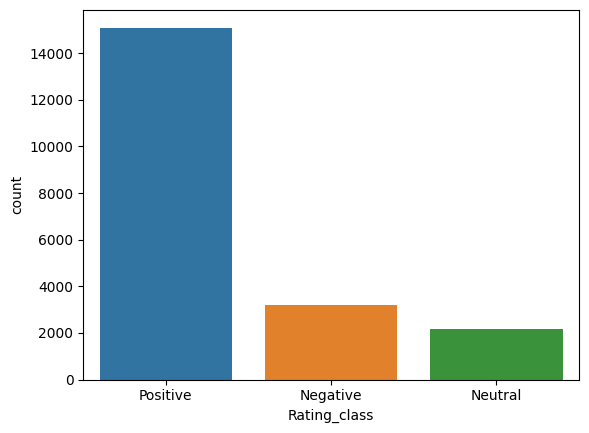

In [10]:
sns.countplot(x='Rating_class', data=data)

In [11]:
data['Review'] = data['Review'].apply(lambda x: x.lower())
data.sample(10)

,Review,Rating_class
7059,"beautiful hotel 3 star service, just returned ...",Negative
19615,beautiful rooms nice view rooms nice simple mo...,Positive
14607,fabulous views huge rooms stayed affinia dumon...,Positive
1077,"best hotel seattle, time stayed kimpton hotel ...",Positive
8848,located recently renovated hotel offers includ...,Positive
2197,incredible view stay wonderful beautiful view ...,Positive
3071,"fabulous, far best inclusive kids possibly, ki...",Positive
6482,placed worked fine arriving sea midnight trave...,Neutral
10313,"avoid street-facing room esp, room 114 husband...",Negative
5242,gorgeous just recently come stay italy 3 night...,Positive


In [12]:
import spacy

nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [13]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['Review'] = data['Review'].apply(remove_stopwords)
data.sample(10)

,Review,Rating_class
7669,bryant park needs work service bryant park hot...,Negative
16997,bad unwelcoming poor service tiny room recomme...,Negative
656,great location wonderful hotel wonderful time ...,Positive
6918,beautiful hotel wondedrful happy champagne hot...,Positive
8364,"loved favourite hotels love, small trendy clea...",Positive
5392,excellent hotel location value lived berlin 18...,Positive
3073,wonderful getaway husband couple 2 year old da...,Positive
15046,"suite, stay suite it__ç_é_ worth, website can_...",Negative
11878,"fantastic, absolutely central location sydney ...",Positive
12273,friendly customer service thing know check 4pm...,Neutral


In [14]:
data.drop_duplicates(subset='Review', keep='first', inplace=True)

In [15]:
a=data[data['Rating_class']== 'Positive'].sample(1000)
b=data[data['Rating_class']== 'Neutral'].sample(1000)
c=data[data['Rating_class']== 'Negative'].sample(1000)

data5k = pd.concat([a,b,c])

In [16]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

data5k['Review'] = data5k['Review'].progress_apply(lemmatize)
data5k.sample(10)

100%|██████████| 3000/3000 [01:07<00:00, 44.55it/s] 


,Review,Rating_class
13204,convenient helpful stay single female great pl...,Positive
11897,officially 5 star 4 star price 2 star standard...,Negative
17361,great deal park fly book hotel park fly websit...,Neutral
10605,"pay save money stay peninsular , main goal sta...",Neutral
9260,nice clean hotel book hotel getaway city - tri...,Neutral
13559,disappointment stay bad room hotel- view inclu...,Negative
11305,mix feeling overall ok girlfriend get one - we...,Neutral
13212,lousy wall lousy internet lousy room service s...,Negative
18487,excellent vacation arrive excellent vacation m...,Positive
12844,great hotel boy friend stay hotel innova 3nigh...,Neutral


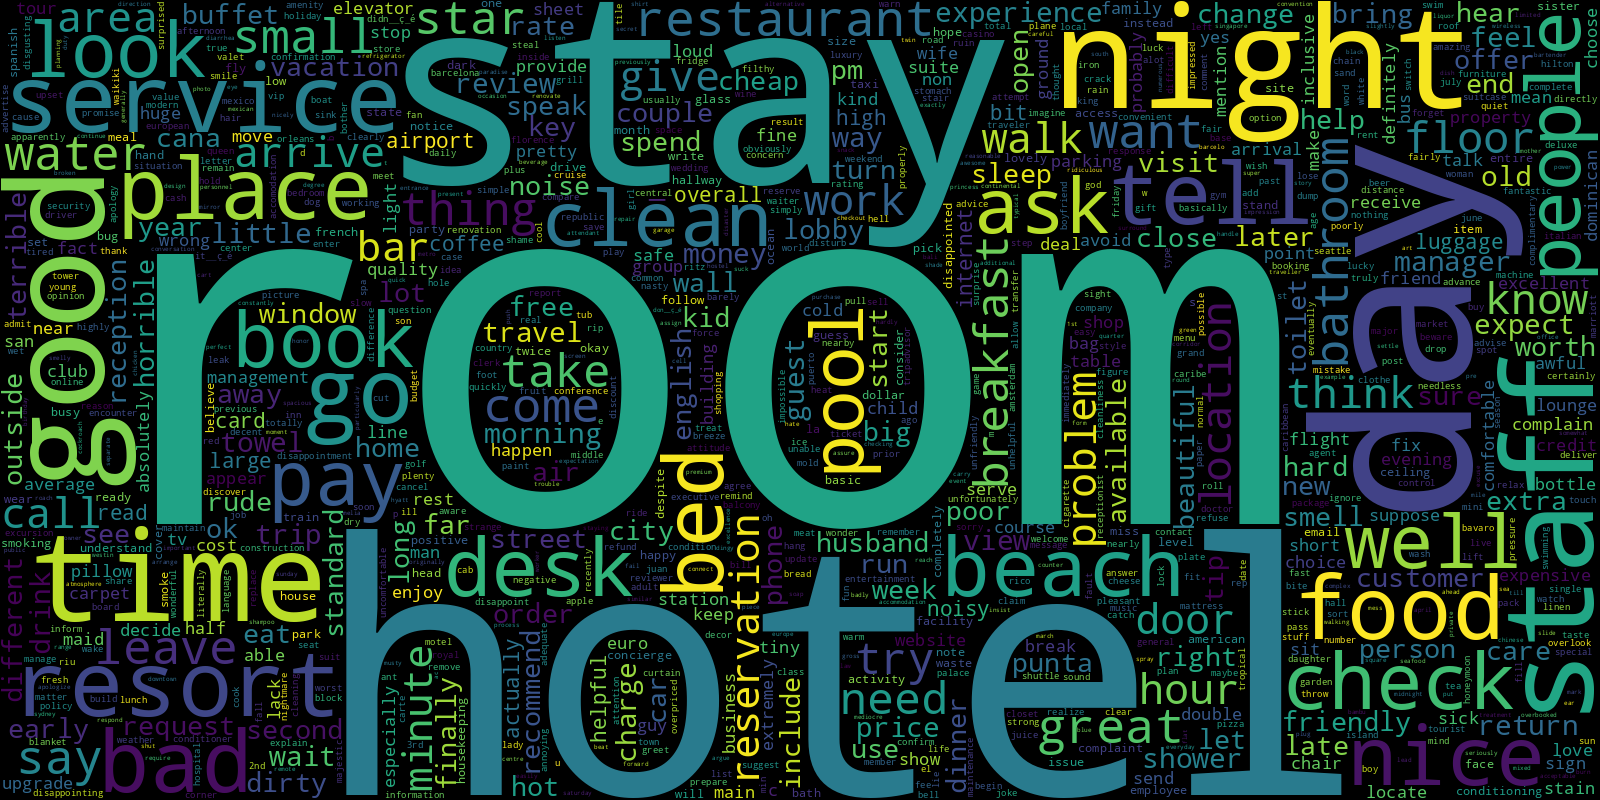

In [17]:
text_neg = ' '.join(data5k[data5k['Rating_class']== 'Negative']['Review'])

wc_neg = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_neg)
wc_neg.to_image()

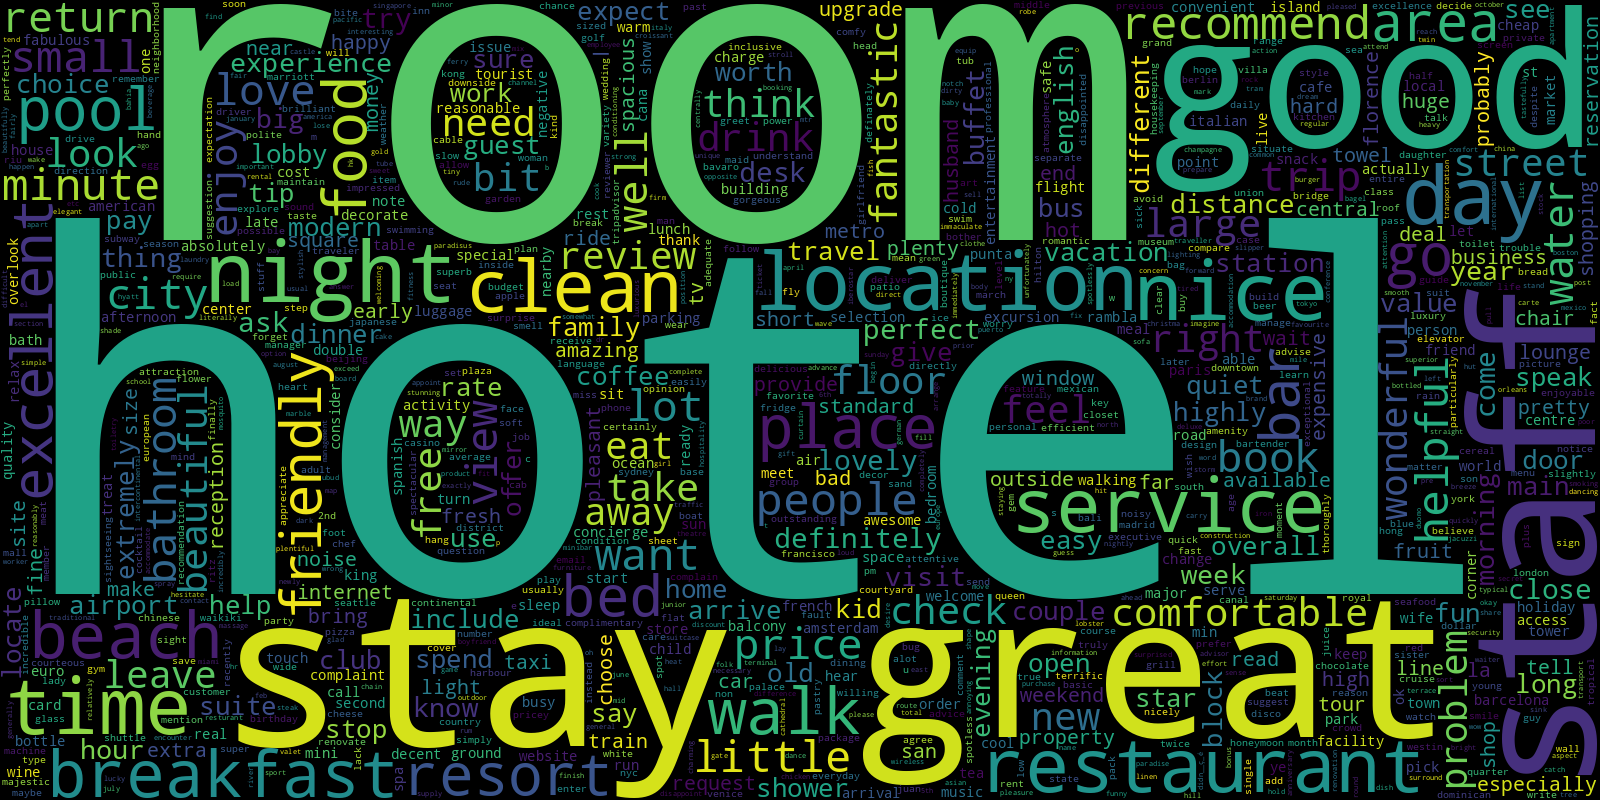

In [18]:
text_pos = ' '.join(data5k[data5k['Rating_class']== 'Positive']['Review'])

wc_pos = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_pos)
wc_pos.to_image()

In [19]:
# Klasyfikacja

# Metoda train_test_split: 10% test, 90% train

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data5k.Review, data5k.Rating_class, test_size=0.1, stratify=data5k.Rating_class)

In [21]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

In [22]:
len(vectorizer.get_feature_names_out())

1000

In [23]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [24]:
print(X_train.shape)
print(X_test.shape)

(2700, 1000)
(300, 1000)


In [25]:
model = BernoulliNB()
model.fit(X_train, y_train)

BernoulliNB()

In [26]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.73      0.80      0.77       100
     Neutral       0.47      0.33      0.39       100
    Positive       0.60      0.73      0.66       100

    accuracy                           0.62       300
   macro avg       0.60      0.62      0.60       300
weighted avg       0.60      0.62      0.60       300



In [27]:
# Sieć GRU

# podczas tworzenia modeli wiele razy zmieniałam parametry, jednak przy chęci wykorzystania w pełni bazy danych dochodziło do
# rozłączenia środowiska wykonawczego. W związku z tym zdecydowałam się na prezentację wyników modelu na okrojonej wersji bazy


!pip install -U portalocker>=2.0.0 -q
!pip install torchtext -q


In [28]:
tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)

In [29]:
data5k.head()

,Review,Rating_class
19369,"perfect , fly girona main concern decent hotel...",Positive
19655,good hotel want excellent service beautiful sp...,Positive
17214,"exceed expectation , friend philly nj ny vacat...",Positive
11211,7 day occidental occidental grand flamenco mar...,Positive
6691,"ask boyfriend spend read week hotel , 23 20 . ...",Positive


In [30]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

data5k['Review'] = data5k['Review'].progress_apply(lemmatize)
data5k.head()

100%|██████████| 3000/3000 [01:01<00:00, 48.76it/s] 


,Review,Rating_class
19369,"perfect , fly girona main concern decent hotel...",Positive
19655,good hotel want excellent service beautiful sp...,Positive
17214,"exceed expectation , friend philly nj ny vacat...",Positive
11211,7 day occidental occidental grand flamenco mar...,Positive
6691,"ask boyfriend spend read week hotel , 23 20 . ...",Positive


In [31]:
data5k['Rating_class'] = data5k['Rating_class'].replace({'Positive':3, 'Neutral':2,
                                                      'Negative': 1})
data5k.head()

,Review,Rating_class
19369,"perfect , fly girona main concern decent hotel...",3
19655,good hotel want excellent service beautiful sp...,3
17214,"exceed expectation , friend philly nj ny vacat...",3
11211,7 day occidental occidental grand flamenco mar...,3
6691,"ask boyfriend spend read week hotel , 23 20 . ...",3


In [32]:
data5k['targets'] = data5k['Rating_class'].astype("category").cat.codes

In [33]:
# liczba klas

K = data5k['targets'].max()+1
K

3

In [34]:
data_train, data_test = train_test_split(data5k,test_size = 0.1)

In [35]:
data_train.head()

,Review,Rating_class,targets
15664,"wow , love ritzzzzzzz , hi , read grumble ritz...",3,2
7418,hotel le suck agree rest poor review hotel rec...,1,0
2500,good visit good trip hotel el convento old san...,3,2
15861,"room claustrophobic stay , room extremely smal...",1,0
19219,extraordinary hospitality o cousin stay proper...,3,2


In [36]:
MAX_VOCAB_SIZE = 2000

tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(data_train['Review'])
sequeces_train = tokenizer.texts_to_sequences(data_train['Review'])
sequeces_test = tokenizer.texts_to_sequences(data_test['Review'])

In [37]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Znaleziono %s uniktowych tokenów.'%V)

Znaleziono 16747 uniktowych tokenów.


In [38]:
df_train = pad_sequences(sequeces_train)
print('Kształt tensora treningowego:', df_train.shape)

Kształt tensora treningowego: (2700, 845)


In [39]:
T = df_train.shape[1]
T

845

In [40]:
df_test = pad_sequences(sequeces_test, maxlen = T)
print('Kształt tensora treningowego:', df_test.shape)

Kształt tensora treningowego: (300, 845)


In [41]:
# Model GRU

import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
model = None
r = None

D = 20

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i)
x = GRU(128, return_sequences = True, activation='tanh')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i,x)

In [43]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

print('Training model single GRU ...')

r = model.fit(
    df_train,
    data_train['targets'],
    epochs = 10,
    batch_size = 128,
    validation_data = (df_test, data_test['targets'])
)

Training model single GRU ...
Epoch 1/10
22/22 [==============================] - 9s 293ms/step - loss: 1.0970 - accuracy: 0.3867 - val_loss: 1.0940 - val_accuracy: 0.4400
Epoch 2/10
22/22 [==============================] - 5s 216ms/step - loss: 1.0873 - accuracy: 0.4278 - val_loss: 1.0772 - val_accuracy: 0.6033
Epoch 3/10
22/22 [==============================] - 3s 146ms/step - loss: 1.0294 - accuracy: 0.5615 - val_loss: 0.9675 - val_accuracy: 0.5567
Epoch 4/10
22/22 [==============================] - 4s 160ms/step - loss: 0.9217 - accuracy: 0.5715 - val_loss: 0.9731 - val_accuracy: 0.5633
Epoch 5/10
22/22 [==============================] - 4s 210ms/step - loss: 0.9102 - accuracy: 0.6652 - val_loss: 0.8763 - val_accuracy: 0.6033
Epoch 6/10
22/22 [==============================] - 2s 100ms/step - loss: 0.7719 - accuracy: 0.6744 - val_loss: 0.7701 - val_accuracy: 0.6067
Epoch 7/10
22/22 [==============================] - 2s 105ms/step - loss: 0.6475 - accuracy: 0.7130 - val_loss: 0.7369

In [44]:
model.save('model_single_GRU.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
def plot_loss_accuracy(r):


  acc = r.history['accuracy']
  val_acc = r.history['val_accuracy']
  loss = r.history['loss']
  val_loss = r.history['val_loss']


  epochs = range(1 ,len(acc) + 1)


  plt.figure(figsize=(15,6))

  plt.subplot(121)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title("Training and validation accuracy", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("accuracy", fontsize=14)
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs, loss, 'go', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title("Training and validation loss", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("loss", fontsize=14)
  plt.legend()

  plt.savefig("model_single_GRU.png")

  plt.show()

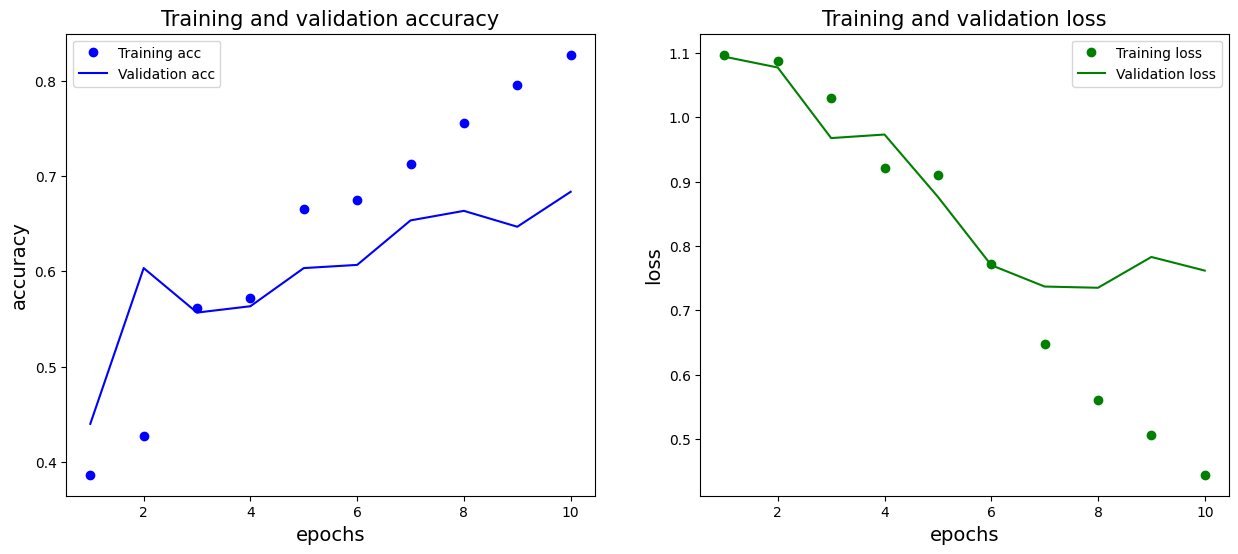

In [46]:
plot_loss_accuracy(r)

In [47]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 845)]             0         
                                                                 
 embedding (Embedding)       (None, 845, 20)           334960    
                                                                 
 gru (GRU)                   (None, 845, 128)          57600     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 392947 (1.50 MB)
Trainable params: 392947 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________

In [48]:
from tensorflow.keras.models import load_model
#model = load_model('model_single_GRU_data.h5')

In [49]:
# model 3GRU

In [50]:
model = None
r = None

D = 20

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i)
x = GRU(128, return_sequences = True, activation='tanh')(x)
x = Dropout(0.2)(x)
x = GRU(128, return_sequences = True, activation='tanh')(x)
x = Dropout(0.2)(x)
x = GRU(128, return_sequences = True, activation='tanh')(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i,x)

In [51]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

print('Training model 3GRU ...')

r2 = model.fit(
    df_train,
    data_train['targets'],
    epochs = 10,
    batch_size = 128,
    validation_data = (df_test, data_test['targets'])
)

Training model 3GRU ...
Epoch 1/10
22/22 [==============================] - 13s 293ms/step - loss: 1.0990 - accuracy: 0.3400 - val_loss: 1.1011 - val_accuracy: 0.3000
Epoch 2/10
22/22 [==============================] - 6s 295ms/step - loss: 1.0746 - accuracy: 0.4370 - val_loss: 0.9158 - val_accuracy: 0.5233
Epoch 3/10
22/22 [==============================] - 7s 315ms/step - loss: 0.8104 - accuracy: 0.6033 - val_loss: 0.7922 - val_accuracy: 0.6000
Epoch 4/10
22/22 [==============================] - 4s 195ms/step - loss: 0.6550 - accuracy: 0.6900 - val_loss: 0.8294 - val_accuracy: 0.5933
Epoch 5/10
22/22 [==============================] - 4s 198ms/step - loss: 0.6127 - accuracy: 0.7237 - val_loss: 0.7948 - val_accuracy: 0.6200
Epoch 6/10
22/22 [==============================] - 5s 213ms/step - loss: 0.4956 - accuracy: 0.7922 - val_loss: 0.7608 - val_accuracy: 0.6167
Epoch 7/10
22/22 [==============================] - 4s 192ms/step - loss: 0.4292 - accuracy: 0.8293 - val_loss: 0.9171 - va

In [52]:
model.save('model_3GRU.h5')

In [53]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 845)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 845, 20)           334960    
                                                                 
 gru_1 (GRU)                 (None, 845, 128)          57600     
                                                                 
 dropout (Dropout)           (None, 845, 128)          0         
                                                                 
 gru_2 (GRU)                 (None, 845, 128)          99072     
                                                                 
 dropout_1 (Dropout)         (None, 845, 128)          0         
                                                                 
 gru_3 (GRU)                 (None, 845, 128)          9907

In [54]:
def plot_loss_accuracy(r2):


  acc = r2.history['accuracy']
  val_acc = r2.history['val_accuracy']
  loss = r2.history['loss']
  val_loss = r2.history['val_loss']


  epochs = range(1 ,len(acc) + 1)


  plt.figure(figsize=(15,6))

  plt.subplot(121)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title("Training and validation accuracy", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("accuracy", fontsize=14)
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs, loss, 'go', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title("Training and validation loss", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("loss", fontsize=14)
  plt.legend()

  plt.savefig("model_3GRU.png")

  plt.show()

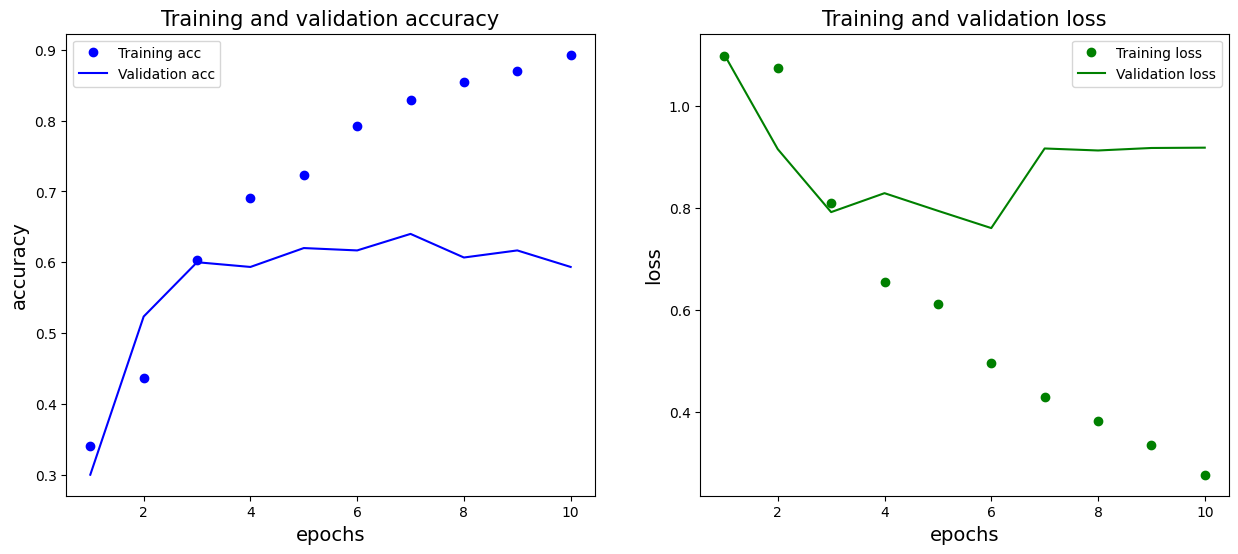

In [55]:
plot_loss_accuracy(r2)

In [56]:
# BiGRU

In [57]:
from tensorflow.keras.layers import Bidirectional

model = None
r = None
r2 = None

D = 20

i = Input(shape = (T,))#
x = Embedding(V + 1, D)(i)
x = Bidirectional(GRU(128, return_sequences = True, activation='tanh'))(x)
x = Dropout(0.2)(x)
x = Bidirectional(GRU(128, return_sequences = True, activation='tanh'))(x)
x = Dropout(0.2)(x)
x = Bidirectional(GRU(128, return_sequences = True, activation='tanh'))(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i,x)

In [58]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

print('Training model BiGRU...')

r3 = model.fit(
    df_train,
    data_train['targets'],
    epochs = 10,
    batch_size = 128,
    validation_data = (df_test, data_test['targets'])
)

Training model BiGRU...
Epoch 1/10
22/22 [==============================] - 21s 535ms/step - loss: 1.0981 - accuracy: 0.3374 - val_loss: 1.0871 - val_accuracy: 0.4567
Epoch 2/10
22/22 [==============================] - 9s 412ms/step - loss: 0.9762 - accuracy: 0.4978 - val_loss: 0.8059 - val_accuracy: 0.5967
Epoch 3/10
22/22 [==============================] - 9s 414ms/step - loss: 0.7253 - accuracy: 0.6719 - val_loss: 0.7426 - val_accuracy: 0.6233
Epoch 4/10
22/22 [==============================] - 9s 429ms/step - loss: 0.5767 - accuracy: 0.7433 - val_loss: 0.7294 - val_accuracy: 0.6567
Epoch 5/10
22/22 [==============================] - 9s 397ms/step - loss: 0.4577 - accuracy: 0.8007 - val_loss: 0.8520 - val_accuracy: 0.6533
Epoch 6/10
22/22 [==============================] - 9s 411ms/step - loss: 0.3951 - accuracy: 0.8393 - val_loss: 0.7957 - val_accuracy: 0.6467
Epoch 7/10
22/22 [==============================] - 9s 405ms/step - loss: 0.2986 - accuracy: 0.8889 - val_loss: 0.9075 - va

In [59]:
model.save('model_BiGRU.h5')

In [60]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 845)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 845, 20)           334960    
                                                                 
 bidirectional (Bidirection  (None, 845, 256)          115200    
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 845, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 845, 256)          296448    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 845, 256)          0   

In [61]:
def plot_loss_accuracy(r3):


  acc = r3.history['accuracy']
  val_acc = r3.history['val_accuracy']
  loss = r3.history['loss']
  val_loss = r3.history['val_loss']


  epochs = range(1 ,len(acc) + 1)


  plt.figure(figsize=(15,6))

  plt.subplot(121)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title("Training and validation accuracy", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("accuracy", fontsize=14)
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs, loss, 'go', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title("Training and validation loss", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("loss", fontsize=14)
  plt.legend()

  plt.savefig("model_BiGRU.png")

  plt.show()

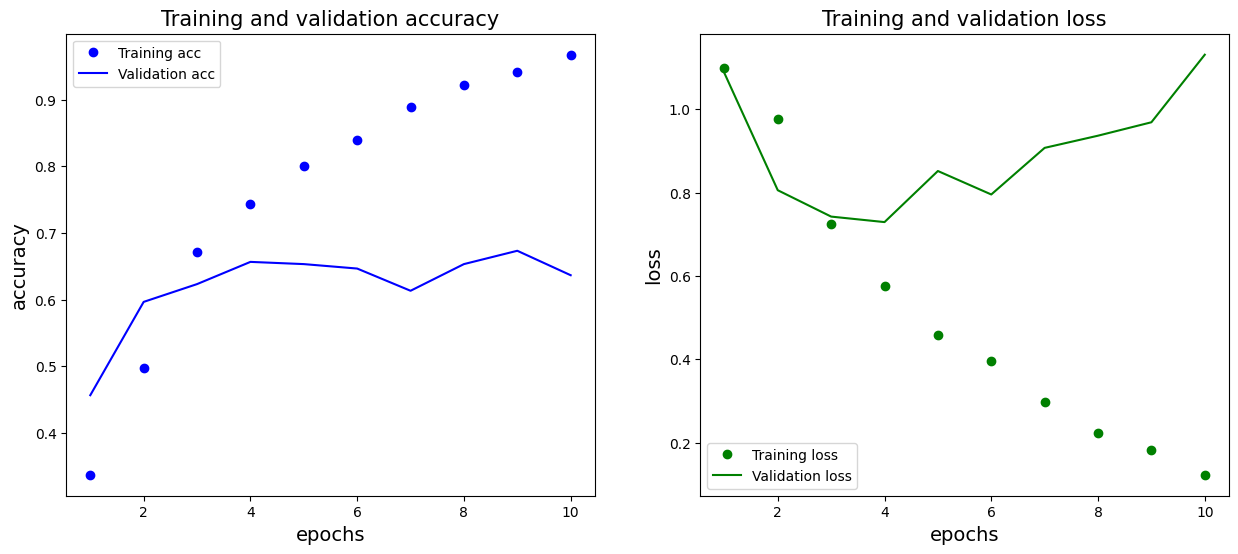

In [62]:
plot_loss_accuracy(r3)

In [64]:
# single BiGru

model = None
r = None

D = 20

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i)
x = Bidirectional(GRU(128, return_sequences = True, activation='tanh'))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i,x)

In [65]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

print('Training model BiGRU...')

r4 = model.fit(
    df_train,
    data_train['targets'],
    epochs = 10,
    batch_size = 128,
    validation_data = (df_test, data_test['targets'])
)

Training model BiGRU...
Epoch 1/10
22/22 [==============================] - 9s 238ms/step - loss: 1.0972 - accuracy: 0.3430 - val_loss: 1.0911 - val_accuracy: 0.4433
Epoch 2/10
22/22 [==============================] - 4s 188ms/step - loss: 1.0791 - accuracy: 0.5152 - val_loss: 1.0949 - val_accuracy: 0.3000
Epoch 3/10
22/22 [==============================] - 7s 305ms/step - loss: 1.0662 - accuracy: 0.4896 - val_loss: 0.9912 - val_accuracy: 0.6567
Epoch 4/10
22/22 [==============================] - 6s 290ms/step - loss: 0.9108 - accuracy: 0.6393 - val_loss: 1.9457 - val_accuracy: 0.3433
Epoch 5/10
22/22 [==============================] - 4s 166ms/step - loss: 0.8632 - accuracy: 0.6300 - val_loss: 0.8415 - val_accuracy: 0.5833
Epoch 6/10
22/22 [==============================] - 6s 283ms/step - loss: 0.7469 - accuracy: 0.6726 - val_loss: 0.7448 - val_accuracy: 0.6400
Epoch 7/10
22/22 [==============================] - 6s 259ms/step - loss: 0.6536 - accuracy: 0.7096 - val_loss: 0.7101 - val

In [66]:
model.save('model_single_BiGRU.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [67]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 845)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 845, 20)           334960    
                                                                 
 bidirectional_3 (Bidirecti  (None, 845, 256)          115200    
 onal)                                                           
                                                                 
 global_max_pooling1d_3 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 450931 (1.72 MB)
Trainable params: 450931 (1.

In [68]:
def plot_loss_accuracy(r4):


  acc = r4.history['accuracy']
  val_acc = r4.history['val_accuracy']
  loss = r4.history['loss']
  val_loss = r4.history['val_loss']


  epochs = range(1 ,len(acc) + 1)


  plt.figure(figsize=(15,6))

  plt.subplot(121)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title("Training and validation accuracy", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("accuracy", fontsize=14)
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs, loss, 'go', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title("Training and validation loss", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("loss", fontsize=14)
  plt.legend()

  plt.savefig("model_single_BiGRU.png")

  plt.show()

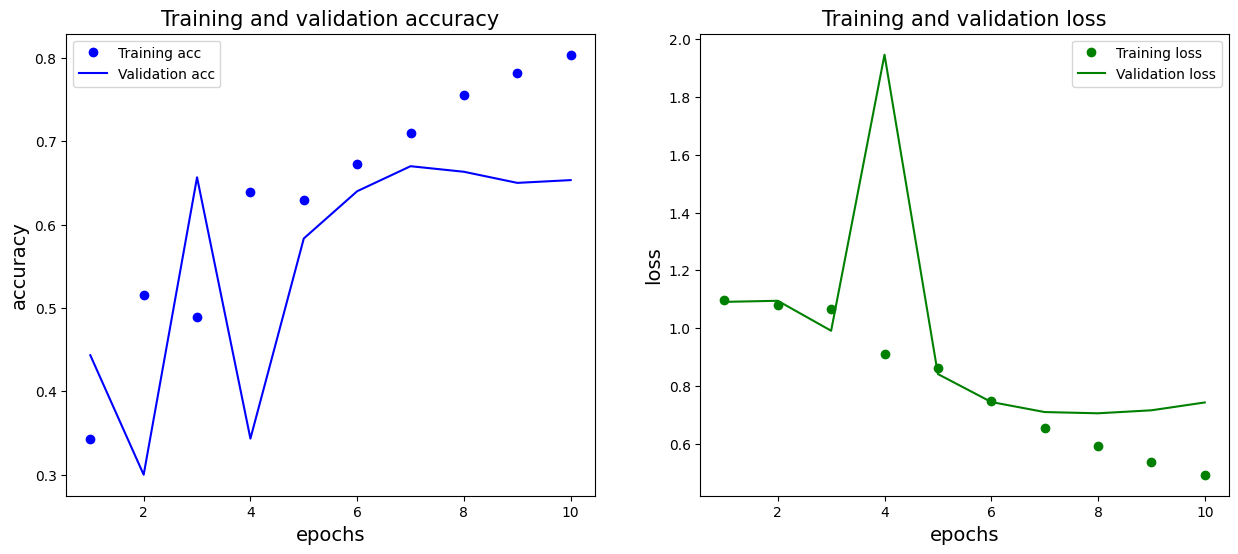

In [69]:
plot_loss_accuracy(r4)

In [70]:
# single BiGru + Dropout

model = None
r = None

D = 20

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i)
x = Bidirectional(GRU(128, return_sequences = True, activation='tanh'))(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i,x)

In [71]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

print('Training model BiGRU...')

r5 = model.fit(
    df_train,
    data_train['targets'],
    epochs = 10,
    batch_size = 128,
    validation_data = (df_test, data_test['targets'])
)

Training model BiGRU...
Epoch 1/10
22/22 [==============================] - 8s 210ms/step - loss: 1.0973 - accuracy: 0.3889 - val_loss: 1.0928 - val_accuracy: 0.3733
Epoch 2/10
22/22 [==============================] - 4s 169ms/step - loss: 1.0814 - accuracy: 0.4463 - val_loss: 1.0748 - val_accuracy: 0.3500
Epoch 3/10
22/22 [==============================] - 5s 226ms/step - loss: 1.0377 - accuracy: 0.4263 - val_loss: 1.0405 - val_accuracy: 0.3600
Epoch 4/10
22/22 [==============================] - 3s 158ms/step - loss: 1.0165 - accuracy: 0.5311 - val_loss: 1.0149 - val_accuracy: 0.6600
Epoch 5/10
22/22 [==============================] - 3s 153ms/step - loss: 0.9585 - accuracy: 0.6707 - val_loss: 0.9664 - val_accuracy: 0.6233
Epoch 6/10
22/22 [==============================] - 3s 148ms/step - loss: 0.8662 - accuracy: 0.6607 - val_loss: 0.8654 - val_accuracy: 0.6333
Epoch 7/10
22/22 [==============================] - 3s 148ms/step - loss: 0.7000 - accuracy: 0.6867 - val_loss: 0.7372 - val

In [72]:
model.save('model_single_BiGRU_Dropout.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [73]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 845)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 845, 20)           334960    
                                                                 
 bidirectional_4 (Bidirecti  (None, 845, 256)          115200    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 845, 256)          0         
                                                                 
 global_max_pooling1d_4 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 3)                 771 

In [74]:
def plot_loss_accuracy(r5):


  acc = r5.history['accuracy']
  val_acc = r5.history['val_accuracy']
  loss = r5.history['loss']
  val_loss = r5.history['val_loss']


  epochs = range(1 ,len(acc) + 1)


  plt.figure(figsize=(15,6))

  plt.subplot(121)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title("Training and validation accuracy", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("accuracy", fontsize=14)
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs, loss, 'go', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title("Training and validation loss", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("loss", fontsize=14)
  plt.legend()

  plt.savefig("model_single_BiGRU_Dropout.png")

  plt.show()

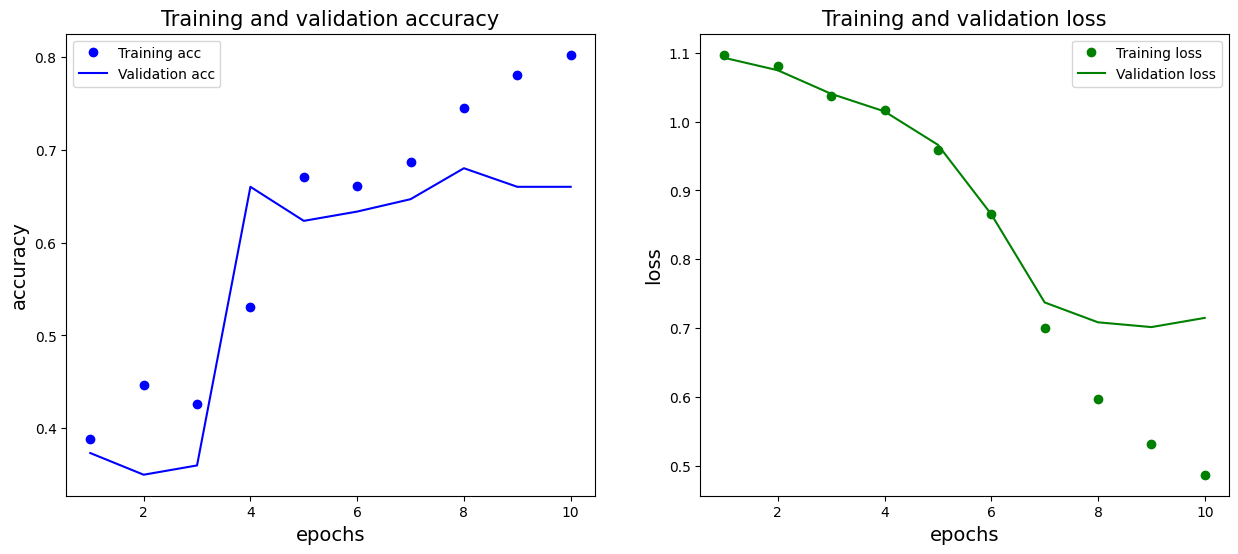

In [75]:
plot_loss_accuracy(r5)

In [76]:
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [78]:
data5k.rename(columns={'targets':'label'}, inplace=True)
data5k.rename(columns={'Review':'text'}, inplace=True)
#del data5k['Rating_class']
data5k.sample(3)

,text,label
1284,disappointing major service issue surprise glo...,1
7414,"fair warning , read hotel le cirque site book ...",0
12035,"good location , oak good location , 5 minute w...",0


In [79]:
from datasets import Dataset
dataset_ = Dataset.from_pandas(data5k)
dataset = dataset_.train_test_split(0.1)

In [80]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2700
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 300
    })
})


In [81]:
model_checkpoint = 'microsoft/deberta-base'
batch_size = 128

In [82]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast = True)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [83]:
tokenizer('recommend hotel reviewer actually stay hotel')

{'input_ids': [1, 43140, 1397, 2303, 37102, 888, 1095, 2303, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [84]:
def process(x):
  return tokenizer(x['text'])

train_ds = dataset['train'].map(process)
eval_ds = dataset['test'].map(process)

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [85]:
train_ds

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2700
})

In [86]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install -U accelerate==0.20.1
#!pip install -U transformers

In [ ]:
import transformers
#!pip install -qqq torch==2.0.1 --progress-bar off
#import accelerate 0.20.1

In [87]:
transformers.__version__, accelerate.__version__

('4.35.2', '0.20.3')

In [88]:
args = TrainingArguments(
    f'{model_checkpoint}_sentiment_analysis',
    evaluation_strategy  = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    num_train_epochs  = 5,
    weight_decay  = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy'
)

In [89]:
from datasets import load_metric
import numpy as np

metric = load_metric('glue','sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis = 1)
  return metric.compute(predictions = predictions, references = labels)

<ipython-input-89-211fb054b740>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue','sst2')


In [90]:
trainer = Trainer(
    model,
    args,
    train_dataset  = train_ds,
    eval_dataset = eval_ds,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

In [91]:
trainer.evaluate([train_ds[0]])

You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.6155427694320679,
 'eval_accuracy': 1.0,
 'eval_runtime': 1.3927,
 'eval_samples_per_second': 0.718,
 'eval_steps_per_second': 0.718}

In [ ]:
trainer.train()

In [93]:
%load_ext tensorboard

In [94]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/demo')

In [95]:
trainer.model

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (

In [101]:
import torch

text = data5k['text'].loc[12219]
inputs = tokenizer(text, return_tensors='pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
  outputs = model(input_ids=input_ids, attention_mask=attention_mask)
  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)

if predictions.item() == 0:
  print("negative example")
elif predictions.item() == 1:
  print("neutral example")
else:
  print("positive example")

negative example


In [102]:
data5k['text'].loc[12219]

'crap motel website , previous review indicate girl reception rude patronise individual , try teach young girl use show joy display type displeasure client opinion acceptable.i feel sorry young girl , room nice pay good , balconys rooftop fool , opera house rocks motel , fiance take birthday gift see opera house pretty annoyed appear website have nasty girl reception help , indicate previous review trouble parking go forth motel car park sort ticket , bad management ,'

In [115]:
data.iloc[12219]

Review          crap motel website, previous reviews indicated...
Rating_class                                             Negative
Name: 12219, dtype: object

In [111]:
import torch

text = data5k['text'].loc[1284]
inputs = tokenizer(text, return_tensors='pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
  outputs = model(input_ids=input_ids, attention_mask=attention_mask)
  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)

if predictions.item() == 0:
  print("negative example")
elif predictions.item() == 1:
  print("neutral example")
else:
  print("positive example")

neutral example


In [113]:
data5k['text'].loc[1284]

'disappointing major service issue surprise glow review property opinion close five - star property way shape form grossly overpriced.i initially book mountain view king , request early check - in know guarantee , arrive 12 noon bellman staff member greet cab , struggle luggage desk , check - in tell room ready take cell number tell ready , big deal go lunch property actually good , hour later have hear news stop tell room ready , finally 3:30pm 30 minute publish check - in time ask assistant manager , come 10 minute room key vague particularly apology abruptly walk , wait minute stand bellman bring luggage escort room , nice bellman walk forever long hallway room overlook mountain room lanai overlook dolphin lagoon , gather consider upgrade ask tell move different category , room look dated bathroom , carpet stain furniture old rust , tv old clunky sony , frankly overlook dolphin captive dolphin program offensive door neighbor smoke smell smoke room get attention , call desk inform re

In [114]:
data.iloc[1284]

Review          disappointing major service issues surprised g...
Rating_class                                              Neutral
Name: 1284, dtype: object

In [131]:
import torch

text = data5k['text'].loc[9108]
inputs = tokenizer(text, return_tensors='pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
  outputs = model(input_ids=input_ids, attention_mask=attention_mask)
  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)

if predictions.item() == 0:
  print("negative example")
elif predictions.item() == 1:
  print("neutral example")
else:
  print("positive example")

negative example
